# Module import

In [84]:
import sys
sys.path.insert(1, "../../module")
import snflics
from skimage.transform import resize
from netCDF4 import Dataset                             
import numpy as np                                      
from scipy.ndimage import zoom
import matplotlib.pyplot as plt                         
from matplotlib.patches import Rectangle                
import cartopy.crs as ccrs                              
import cartopy.feature as cfeature                   
import warnings
warnings.filterwarnings("ignore")
plt.style.use('default')                               
plt.rcParams['figure.facecolor'] = 'white'

# Geodata

- lats.shape == lons.shape == cores.shape == (2268, 2080) 
- lats and lons give the geolocation for each pixel in cores
- But the grid is not regular in geographic space — i.e., spacing between neighbouring lat/lon values varies across the array
- curvilinear grid

In [4]:
geodata = np.load("../../data/geodata/lat_lon_2268_2080.npz")
lons = geodata["lon"][:]
lats = geodata["lat"][:]

In [33]:
def to_yx(lat, lon, lats, lons):    
    """
    Finds the approximate grid indices (y, x) corresponding to a given latitude and longitude 
    in a grid defined by `lats` and `lons` arrays, with a tolerance of approximately 3 km 
    around the specified latitude and longitude.

    Parameters:
    ----------
    lat : float
        The target latitude (in degrees) for which to find the nearest grid point.
    lon : float
        The target longitude (in degrees) for which to find the nearest grid point.
    lats : numpy.ndarray
        A 2D array of latitudes representing the grid.
    lons : numpy.ndarray
        A 2D array of longitudes representing the grid.
    
    Returns:
    -------
    y : int
        The index along the latitude dimension of the grid where the target latitude is found.
    x : int
        The index along the longitude dimension of the grid where the target longitude is found.
    """
    
    # Calculate the absolute difference from the target latitude and longitude
    lat_diff = np.abs(lats - lat)
    lon_diff = np.abs(lons - lon)

    # Calculate the tolerance in degrees for 3 km (based on the approximations)
    lat_tol = 3 / 111  # 1 degree of latitude ~ 111 km
    lon_tol = 3 / 104  # 1 degree of longitude ~ 104 km (approximated)

    # Find the indices where the differences are within the tolerance
    lat_mask = lat_diff <= lat_tol
    lon_mask = lon_diff <= lon_tol

    # Combine the latitude and longitude masks to find the matching grid points
    valid_indices = np.argwhere(lat_mask & lon_mask)

    if valid_indices.size > 0:
        # If matching indices are found, return the median indices
        y, x = np.median(valid_indices, axis=0).astype(int)
        return y, x
    else:
        # If no matching points are found, raise an error or handle gracefully
        raise ValueError("No matching grid point found within the tolerance")

# Core data

In [5]:
file = "../../data/core/202307031815.nc"
data = Dataset(file, mode='r')

cores = data["cores"][0, :, :]
raw_cores = np.copy(cores)

lat = data["max_lat"][:]
lon = data["max_lon"][:]

Dakar_lon = -17.467686
Dakar_lat = 14.716677

temp = data["tir"][0, :, :]
binary_cores = (cores != 0).astype(int)

# Dakar Context Domain

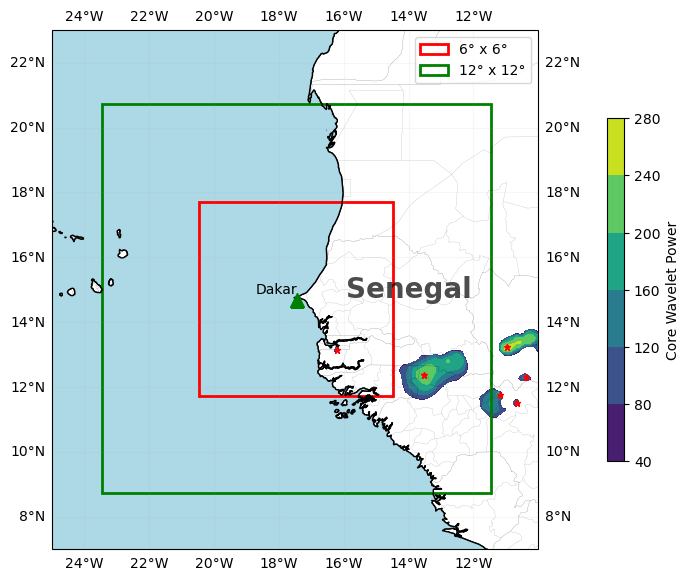

In [6]:
# Define extent
extent = (-25, -10, 7, 23)

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Force background to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Set map extent
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.1)
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Force LAND to be white
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')  # Optional

gl = ax.gridlines(xlocs=np.arange(-26, -8, 2), 
                  ylocs=np.arange(8, 23, 2), 
                  draw_labels=True, 
                  crs=ccrs.PlateCarree(),
                  alpha=0.1
                )

# Add administrative borders
admin_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none'
)

ax.add_feature(admin_borders, edgecolor='black', linewidth=0.06)
#contour_presence = ax.contourf(lons, lats, binary_cores, levels = [0.5, 1] ,transform=ccrs.PlateCarree(), cmap="afmhot")
contour_core = ax.contourf(lons, lats, cores, levels=[40, 80, 120, 160, 200, 240, 280], transform=ccrs.PlateCarree(), cmap="viridis")
#plt.contour(lons, lats, cores, levels=[0], colors='red', transform=ccrs.PlateCarree())  

cbar_core = plt.colorbar(contour_core, fraction=0.03, pad=0.12)
cbar_core.set_label("Core Wavelet Power")

ax.text(-14, 15, "Senegal", fontsize=20, fontweight="bold", color="black",
        transform=ccrs.PlateCarree(), ha="center", va="center", alpha=0.7)


box_sizes = [6, 12]
colors = ['red', 'green']
labels = ['6° x 6°', '12° x 12°']

# Add rectangles
for size, color, label in zip(box_sizes, colors, labels):
    lower_left_lon = Dakar_lon - size / 2
    lower_left_lat = Dakar_lat - size / 2
    rect = Rectangle((lower_left_lon, lower_left_lat), size, size,
                     linewidth=2, edgecolor=color, facecolor='none', label=label)
    ax.add_patch(rect)

for lt, ln in zip(lat, lon):    
  plt.plot(ln, lt, marker="*", color="red", markersize=5)

# Plot a marker at Dakar's location
Dakar_lon, Dakar_lat = -17.45, 14.69
plt.plot(Dakar_lon, Dakar_lat, marker="^", color="green", markersize=10)
plt.text(Dakar_lon, Dakar_lat+0.1, "Dakar", ha="right", va="bottom")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
for size, label in zip(box_sizes, labels):
    lower_left_lon = Dakar_lon - size / 2
    lower_left_lat = Dakar_lat - size / 2
    print(label, lower_left_lat, lower_left_lon)

6° x 6° 11.69 -20.45
12° x 12° 8.69 -23.45


In [52]:
Dakar_y, Dakar_x = snflics.to_yx(Dakar_lat, Dakar_lon, lats, lons)

In [ ]:
def extract_box(data, y, x, box_size=5, spacing_km=3):
    """
    Extracts a square region around a central grid point and calculates area coverage.

    Parameters:
    -----------
    data : np.ndarray
        2D array from which to extract the box (e.g., cores).
    y, x : int
        Central grid indices.
    box_size : int
        Size of the square box (must be odd), e.g., 5 for a 5x5 box.
    spacing_km : float
        Grid spacing in kilometres.

    Returns:
    --------
    box : np.ndarray
        The extracted subregion.
    extent_km : float
        The physical width/height (in km) of the area covered.
    """
    assert box_size % 2 == 1, "box_size must be odd"
    
    half = box_size // 2
    y_min = max(0, y - half)
    y_max = min(data.shape[0], y + half + 1)
    x_min = max(0, x - half)
    x_max = min(data.shape[1], x + half + 1)
    
    box = data[y_min:y_max, x_min:x_max]
    extent_km = (box.shape[0] - 1) * spacing_km  # physical size from number of intervals

    return box, extent_km

In [61]:
Dakar_core = extract_box(cores, Dakar_y, Dakar_x)

In [58]:
cores[Dakar_y-1:Dakar_y+2, Dakar_x-1:Dakar_x+2]

masked_array(
  data=[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],
  mask=False,
  fill_value=999999,
  dtype=int16)

# Context Domain Coordinates for Dakar

In [8]:
# Shorter lead time
Dakar_context_short_lt_lat_min = 11.69
Dakar_context_short_lt_lat_max = Dakar_context_short_lt_lat_min + 6

Dakar_context_short_lt_lon_min = -20.45
Dakar_context_short_lt_lon_max = Dakar_context_short_lt_lon_min + 6

# Longer lead time
Dakar_context_long_lt_lat_min = 8.69
Dakar_context_long_lt_lat_max = Dakar_context_long_lt_lat_min + 12

Dakar_context_long_lt_lon_min = -23.45
Dakar_context_long_lt_lon_max = Dakar_context_long_lt_lon_min + 12

# Senegal extent

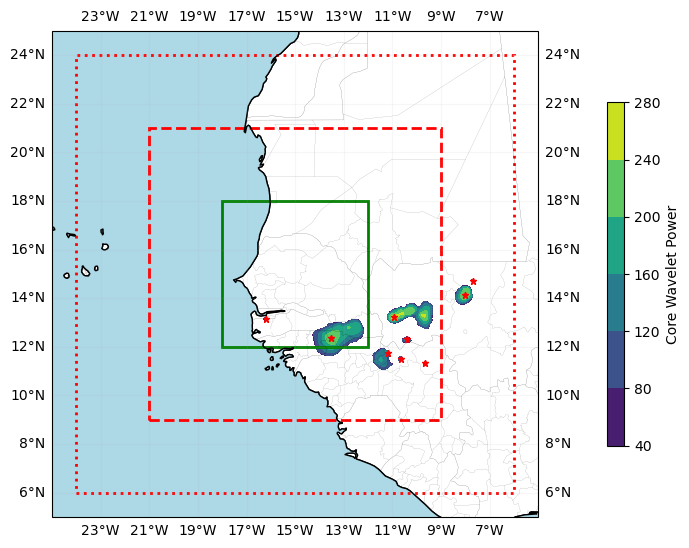

In [9]:
# Define extent
extent = (-25, -5, 5, 25)

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Force background to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Set map extent
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.1)
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Force LAND to be white
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')  # Optional

gl = ax.gridlines(xlocs=np.arange(-23, -5, 2), 
                  ylocs=np.arange(6, 25, 2), 
                  draw_labels=True, 
                  crs=ccrs.PlateCarree(),
                  alpha=0.1
                )

# Add administrative borders
admin_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none'
)

ax.add_feature(admin_borders, edgecolor='black', linewidth=0.06)
#contour_presence = ax.contourf(lons, lats, binary_cores, levels = [0.5, 1] ,transform=ccrs.PlateCarree(), cmap="afmhot")
contour_core = ax.contourf(lons, lats, cores, levels=[40, 80, 120, 160, 200, 240, 280], transform=ccrs.PlateCarree(), cmap="viridis")
#plt.contour(lons, lats, cores, levels=[0], colors='red', transform=ccrs.PlateCarree())  

cbar_core = plt.colorbar(contour_core, fraction=0.03, pad=0.12)
cbar_core.set_label("Core Wavelet Power")

# Add the 6x6 square (green)
ax.add_patch(Rectangle((-18.0, 12.0), 6, 6, edgecolor='green', facecolor='none', linewidth=2))

# Add the 12x12 square (red)
ax.add_patch(Rectangle((-21.0, 9.0), 12, 12, edgecolor='red', facecolor='none', linewidth=2, linestyle="dashed"))

# Add the 18x18 square (red)
ax.add_patch(Rectangle((-24.0, 6.0), 18, 18, edgecolor='red', facecolor='none', linewidth=2, linestyle="dotted"))

for lt, ln in zip(lat, lon):    
  plt.plot(ln, lt, marker="*", color="red", markersize=5)

plt.tight_layout()
plt.show()


# Context Domain Coordinates for Senegal

In [10]:
# Domain of interest
Senegal_lon_min = -18.0
Senegal_lon_max = Senegal_lon_min + 6

Senegal_lat_min = 12.0
Senegal_lat_max = Senegal_lat_min + 6

# Context domain for shorter lead times
Senegal_context_short_lt_lon_min = -21.0
Senegal_context_short_lt_lon_max = Senegal_context_short_lt_lon_min + 12

Senegal_context_short_lt_lat_min = 9.0
Senegal_context_short_lt_lat_max = Senegal_context_short_lt_lat_min + 12

# Context domain for longer lead times
Senegal_context_long_lt_lon_min = -24.0
Senegal_context_long_lt_lon_max = Senegal_context_long_lt_lon_min + 18

Senegal_context_long_lt_lat_min = 6.0
Senegal_context_long_lt_lat_max = Senegal_context_long_lt_lat_min + 18

In [64]:
Senegal_y_min, Senegal_x_min = snflics.to_yx(Senegal_lat_min, Senegal_lon_min, lats, lons)
Senegal_y_max, Senegal_x_max = snflics.to_yx(Senegal_lat_max, Senegal_lon_max, lats, lons)

In [ ]:
Senegal_y_min, Senegal_x_min = 1650, 96
Senegal_y_max, Senegal_x_max = 1861, 315

In [73]:
lats

array([[ -37.558388,  -37.556046,  -37.553616, ..., -999.999   ,
        -999.999   , -999.999   ],
       [ -37.51846 ,  -37.516144,  -37.51369 , ..., -999.999   ,
        -999.999   , -999.999   ],
       [ -37.478493,  -37.476055,  -37.47351 , ..., -999.999   ,
        -999.999   , -999.999   ],
       ...,
       [  24.833788,   24.83266 ,   24.831459, ...,   27.136353,
          27.145126,   27.153954],
       [  24.865915,   24.864788,   24.863512, ...,   27.1753  ,
          27.184128,   27.193235],
       [  24.898012,   24.896885,   24.895674, ...,   27.214367,
          27.223099,   27.232262]], dtype=float32)

In [ ]:
print(Senegal_y_min, Senegal_x_min)
print(Senegal_y_max, Senegal_x_max)

1650 96
1861 315


In [74]:
print(lats[1650, 96], lons[1650, 96])   # Southwest corner
print(lats[1861, 315], lons[1861, 315]) # Northeast corner

11.975635 -18.022882
17.980268 -12.022928


In [85]:
Senegal_core = cores[Senegal_y_min:Senegal_y_max+1, Senegal_x_min:Senegal_x_max+1]
Senegal_domain_lats = lats[Senegal_y_min:Senegal_y_max+1, Senegal_x_min:Senegal_x_max+1]
Senegal_domain_lons = lons[Senegal_y_min:Senegal_y_max+1, Senegal_x_min:Senegal_x_max+1]

In [86]:
Senegal_core.shape

(212, 220)

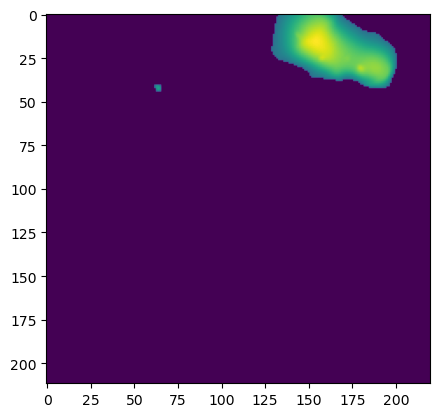

In [87]:
plt.imshow(Senegal_core)

In [88]:
target_shape = (128, 128)
zoom_factors = (
    target_shape[0] / Senegal_core.shape[0],
    target_shape[1] / Senegal_core.shape[1],
)

Senegal_core_resized = zoom(Senegal_core, zoom=zoom_factors, order=1)  # bilinear interpolation

In [89]:
Senegal_core_resized.shape

(128, 128)

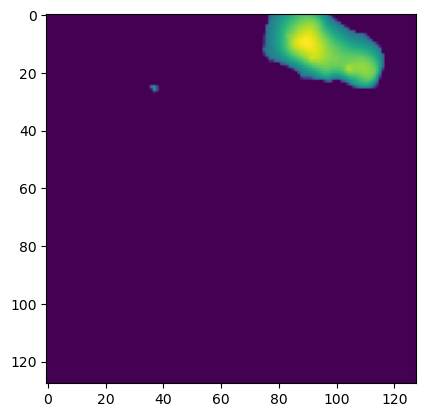

In [90]:
plt.imshow(Senegal_core_resized)

In [91]:
lats_resized = resize(Senegal_domain_lats, (128, 128), mode='reflect', anti_aliasing=True)
lons_resized = resize(Senegal_domain_lons, (128, 128), mode='reflect', anti_aliasing=True)

In [ ]:
lats_resized

array([[11.985137 , 11.984461 , 11.98383  , ..., 11.916121 , 11.915686 ,
        11.915265 ],
       [12.031754 , 12.031085 , 12.030442 , ..., 11.96249  , 11.962043 ,
        11.961625 ],
       [12.0788145, 12.078147 , 12.077494 , ..., 12.009249 , 12.008786 ,
        12.008368 ],
       ...,
       [17.984303 , 17.98322  , 17.982185 , ..., 17.874449 , 17.873745 ,
        17.873064 ],
       [18.033459 , 18.032398 , 18.0314   , ..., 17.923298 , 17.922564 ,
        17.921894 ],
       [18.082275 , 18.081202 , 18.08015  , ..., 17.971716 , 17.971035 ,
        17.97036  ]], dtype=float32)

# Focus on Senegal

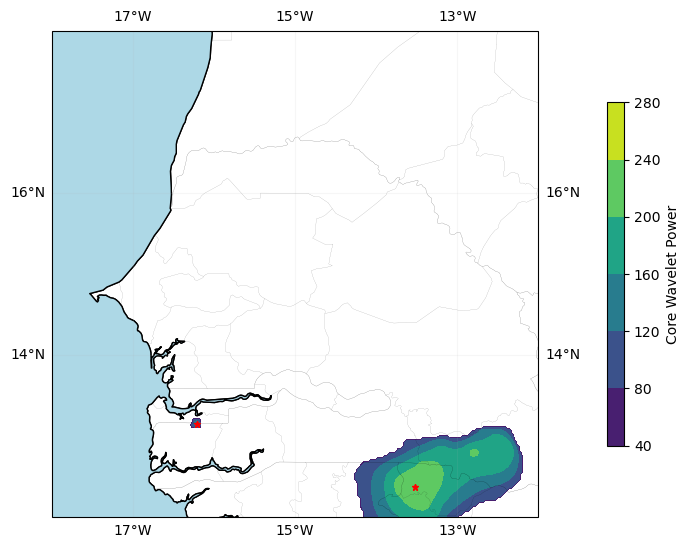

In [ ]:
# Define extent
extent = (-18, -12, 12, 18)

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Force background to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Set map extent
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.1)
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Force LAND to be white
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')  # Optional

gl = ax.gridlines(xlocs=np.arange(-23, -5, 2), 
                  ylocs=np.arange(6, 25, 2), 
                  draw_labels=True, 
                  crs=ccrs.PlateCarree(),
                  alpha=0.1
                )

# Add administrative borders
admin_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none'
)

ax.add_feature(admin_borders, edgecolor='black', linewidth=0.06)
contour_core = ax.contourf(lons, lats, cores, levels=[40, 80, 120, 160, 200, 240, 280], transform=ccrs.PlateCarree(), cmap="viridis")

cbar_core = plt.colorbar(contour_core, fraction=0.03, pad=0.12)
cbar_core.set_label("Core Wavelet Power")

for lt, ln in zip(lat, lon):    
  plt.plot(ln, lt, marker="*", color="red", markersize=5)

plt.tight_layout()
plt.show()

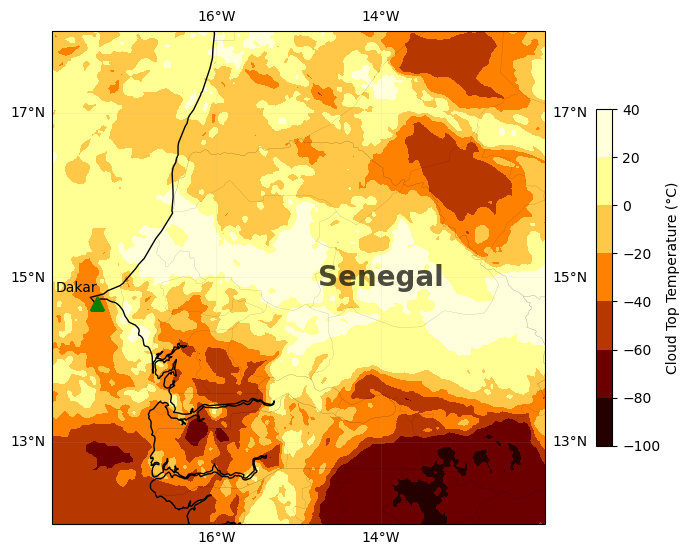

In [12]:
# Define extent
extent = (-18, -12, 12, 18)

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# Force background to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Set map extent
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.1)
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Force LAND to be white
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')  # Optional

gl = ax.gridlines(xlocs=np.array([-18, -16, -14, -12]), 
                  ylocs=np.array([11, 13, 15, 17]), 
                  draw_labels=True, 
                  crs=ccrs.PlateCarree(),
                  alpha=0.1
                )

# Add administrative borders
admin_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none'
)

ax.add_feature(admin_borders, edgecolor='black', linewidth=0.06)
contour_temperature = ax.contourf(lons, lats, temp,transform=ccrs.PlateCarree(), cmap="afmhot")
cbar_temperature = plt.colorbar(contour_temperature, fraction=0.03, pad=0.09)
cbar_temperature.set_label("Cloud Top Temperature (°C)")

#plt.contour(lons, lats, cores, levels=[0], colors='cyan', transform=ccrs.PlateCarree())  

# for lt, ln in zip(lat, lon):    
#   plt.plot(ln, lt, marker="*", color="red", markersize=5)


ax.text(-14, 15, "Senegal", fontsize=20, fontweight="bold", color="black",
        transform=ccrs.PlateCarree(), ha="center", va="center", alpha=0.7)

# Plot a marker at Dakar's location
Dakar_lon, Dakar_lat = -17.45, 14.69
plt.plot(Dakar_lon, Dakar_lat, marker="^", color="green", markersize=10)
plt.text(Dakar_lon, Dakar_lat+0.1, "Dakar", ha="right", va="bottom")
plt.tight_layout()
plt.show()
